In [1]:
!nvidia-smi -L
from google.colab import drive
drive.mount('/content/drive')


GPU 0: Tesla K80 (UUID: GPU-59965c0d-b60c-0ad1-f613-d0cba89f518e)
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Install Models

In [2]:
%cd /content
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
#!pip install jupyter
#!pip install matplotlib

!git clone https://github.com/tensorflow/models.git

%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

import sys
sys.path.append('/content/models/research/slim')

!python object_detection/builders/model_builder_test.py

/content
Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.16-2~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 7 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,688 kB of additional disk space will be used.
G

# Set Constants


In [0]:
import os
PROJECT_ROOT = "/content/drive/My Drive/rob535"
TEST_FILES = "/content/drive/My Drive/rob535/test"
TRAIN_FILES = "/content/drive/My Drive/rob535/trainval"

STAGE_1 = os.path.join(PROJECT_ROOT, "stage1")

# Imports

In [0]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import glob
import tensorflow as tf
import numpy as np
import random

from object_detection.utils import dataset_util

!pip show tensorflow

# Check Files

In [0]:
#CHECKS TO MAKE SURE ALL FILES ARE HERE
if sys.platform.startswith('win32'):
    data_dir = "C:\\Users\\Chris\\Documents\\ROB535 Project\\data-2019"
else:
    data_dir = "/content/drive/Shared drives/AV Dream Team/Perception Group/Perception_Data/data-2019/"

train_bbox = glob.glob(os.path.join(data_dir, "trainval/*/*bbox.bin"))
train_images = glob.glob(os.path.join(data_dir, "trainval/*/*image.jpg"))
train_proj = glob.glob(os.path.join(data_dir, "trainval/*/*proj.bin"))
train_cloud = glob.glob(os.path.join(data_dir, "trainval/*/*cloud.bin"))
test_proj = glob.glob(os.path.join(data_dir, "test/*/*proj.bin"))
test_images = glob.glob(os.path.join(data_dir, "test/*/*image.jpg"))
test_cloud = glob.glob(os.path.join(data_dir, "test/*/*cloud.bin"))

# glob ordering not guaranteeed
# assume all same size and that bbox, jpg, proj, and cloud are availabel for every sample
sorted(train_bbox)
sorted(train_images)
sorted(train_proj)
sorted(train_cloud)
sorted(test_proj)
sorted(test_images)
sorted(test_cloud)

# check to make sure shit's ordered correctly
assert(len(train_bbox) == len(train_images))
assert(len(train_bbox) == len(train_proj))
assert(len(train_proj) == len(train_cloud))
assert(len(test_proj) == len(test_images))
assert(len(test_proj) == len(test_cloud))

for i in range(0, len(train_bbox)):
    assert (os.path.split(train_bbox[i])[0] == os.path.split(train_images[i])[0])
    assert (os.path.split(train_bbox[i])[0] == os.path.split(train_proj[i])[0])
    assert (os.path.split(train_bbox[i])[0] == os.path.split(train_cloud[i])[0])
for i in range(0, len(test_images)):
    assert (os.path.split(test_images[i])[0] == os.path.split(test_proj[i])[0])
    assert (os.path.split(test_images[i])[0] == os.path.split(test_cloud[i])[0])

print("Files all seem ok")

Files all seem ok


# Create Record Files For Training

In [0]:
def rot(n):
    n = np.asarray(n).flatten()
    assert(n.size == 3)

    theta = np.linalg.norm(n)
    if theta:
        n /= theta
        K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

        return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    else:
        return np.identity(3)


def get_bbox(p0, p1):
    """
    Input:
    *   p0, p1
        (3)
        Corners of a bounding box represented in the body frame.

    Output:
    *   v
        (3, 8)
        Vertices of the bounding box represented in the body frame.
    *   e
        (2, 14)
        Edges of the bounding box. The first 2 edges indicate the `front` side
        of the box.
    """
    v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]
    ])
    e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]
    ], dtype=np.uint8)

    return v, e


In [0]:
VEH_LIST = ["Unknown", "Compact", "Sedan", "SUV", "Coupe", "Muscle", "SportsClassic", "Sport",
            "Super", "Motorcycle", "Offroad", "Industrial", "Utility", "Van", "Cycle", "Boat", "Helicopter",
            "Plane", "Service", "Emergency", "Military", "Commercial", "Trains"]

def class_int_to_text(num):
    return VEH_LIST[num]


def create_tf_example(image_path):
    # TODO(user): Populate the following variables from your example.
    height = 1052 # Image height
    width = 1914 # Image width
    filename = image_path # Filename of the image. Empty if image is not from file
    image_format = b'jpg' # b'jpeg' or b'png'

    with tf.io.gfile.GFile(image_path, "rb") as fid:
        encoded_image_data = fid.read()

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    classes_text = []  # List of string class name of bounding box (1 per box)
    classes = []  # List of integer class id of bounding box (1 per box)

    proj = np.fromfile(image_path.replace("_image.jpg", "_proj.bin"), dtype=np.float32)
    proj.resize([3, 4])
    bbox = np.fromfile(image_path.replace("_image.jpg", "_bbox.bin"), dtype=np.float32)
    bbox = bbox.reshape([-1, 11])

    for k, b in enumerate(bbox):
        R = rot(b[0:3])
        t = b[3:6]
        sz = b[6:9]

        vert_3D, edges = get_bbox(-sz / 2, sz / 2)
        vert_3D = R @ vert_3D + t[:, np.newaxis]

        vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
        vert_2D = vert_2D / vert_2D[2, :]

        xmin = min(vert_2D[0, :])
        xmax = max(vert_2D[0, :])
        ymin = min(vert_2D[1, :])
        ymax = max(vert_2D[1, :])

        xmins.append(xmin/width)
        xmaxs.append(xmax/width)
        ymins.append(ymin/height)
        ymaxs.append(ymax/height)

        classes.append(int(b[9]) + 1)
        classes_text.append(class_int_to_text(int(b[9])).encode('utf-8'))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename.encode("utf-8")),
        'image/source_id': dataset_util.bytes_feature(filename.encode("utf-8")),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

# main
writer_train = tf.io.TFRecordWriter(os.path.join(STAGE_1, 'train.record'))
writer_test = tf.io.TFRecordWriter(os.path.join(STAGE_1, 'test.record'))

images = glob.glob(os.path.join(TEST_FILES, "/*/*image.jpg"))
random.shuffle(images)
num_test = int(0.2*len(images))
test_images = images[0:num_test]
train_images = images[num_test:]
print(num_test)

for image_path in train_images:
    tf_example = create_tf_example(image_path)
    writer_train.write(tf_example.SerializeToString())

writer_train.close()

for image_path in test_images:
    tf_example = create_tf_example(image_path)
    writer_test.write(tf_example.SerializeToString())

writer_test.close()

# Train Model


In [0]:
#extract model, edit pipeline.config, and copy pipeline.config to stage1/
#%cd "/content/drive/My Drive/rob535"
os.chdir(PROJECT_ROOT)
#!tar -xzvf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
!tar -xzvf faster_rcnn_resnet101_coco_2018_01_28.tar.gz

In [0]:
#need to run this stuff once per session to make shit work
%cd /content/models/research
!python setup.py build
!python setup.py install
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

#need to copy modified model_lib.py to folder - modified to set evaluation throttle_sec to 3600 to prevent constant evals
#hack but it works
#!cp "/content/drive/My Drive/rob535/model_lib.py" "/content/models/research/object_detection/model_lib.py"
src = os.path.join(PROJECT_ROOT, "model_lib.py")
!cp "$src" "/content/models/research/object_detection/model_lib.py"

In [0]:
#%cd "/content/drive/My Drive/rob535"
os.chdir(PROJECT_ROOT)
!python /content/models/research/object_detection/model_main.py --logtostderr --model_dir=stage1 --pipeline_config_path=stage1/pipeline.config

# Run on testing images

In [0]:
import pickle
import subprocess
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import time

from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util

In [0]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def run_inference_for_single_image(image, graph):
    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    # Run inference
    output_dict = sess.run(tensor_dict,
                           feed_dict={image_tensor: np.expand_dims(image, 0)})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

def rot(n):
    n = np.asarray(n).flatten()
    assert(n.size == 3)

    theta = np.linalg.norm(n)
    if theta:
        n /= theta
        K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

        return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    else:
        return np.identity(3)


def get_bbox(p0, p1):
    v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]
    ])
    e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]
    ], dtype=np.uint8)

    return v, e


In [0]:
# Generate Estimated bbox for all files and save into a dictionary

os.chdir(STAGE_1)
print(os.getcwd())
PATH_TO_FROZEN_GRAPH = "inference_graph"
MODEL_NAME = "model.ckpt-95036"
PATH_TO_LABELS = "label-map.pbtxt"

data_dir = TEST_FILES
FUN_LOC = "/content/models/research/object_detection/export_inference_graph.py"

# BUILD MODEL FROM FROZEN TRAIN MODEL
if PATH_TO_FROZEN_GRAPH not in os.listdir((os.getcwd())):
    print("creating inference graph")
    out = subprocess.check_output([sys.executable,
                    FUN_LOC,
                     '--input_type', 'image_tensor',
                     '--pipeline_config_path', 'pipeline.config',
                     '--trained_checkpoint_prefix', MODEL_NAME,
                     '--output_directory', PATH_TO_FROZEN_GRAPH], stderr=subprocess.STDOUT)
    print(out)

PATH_TO_FROZEN_GRAPH = os.path.join(PATH_TO_FROZEN_GRAPH, "frozen_inference_graph.pb")

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

images = glob.glob(os.path.join(data_dir, "*/*image.jpg"))
#test_images = random.sample(images, 10)
test_images = images

with detection_graph.as_default():
    with tf.Session() as sess:
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
          ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
        detections = []
        count = 0
        start = time.time()
        for image_path in test_images:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            output_dict = run_inference_for_single_image(image_np, detection_graph)
            # Visualization of the results of a detection.
            tmp = {"path": image_path, "bbox": [], "label": []}
            for i in range(0, output_dict["num_detections"]):
                tmp["bbox"].append(output_dict["detection_boxes"][i])
                tmp["label"].append(output_dict["detection_classes"][i])
            detections.append(tmp)
            count = count + 1
            if not count % 100:
              print(count, time.time() - start)

        f = open("calculated_bbox-train.pkl", "wb")
        pickle.dump(detections, f)
        f.close()
print("done")


/content/drive/My Drive/rob535/stage1
/content/drive/My Drive/rob535/test/0382f411-9b8a-47dc-bd88-eac8245a28ee/0042_image.jpg
[2, 2, 1, 3, 2]


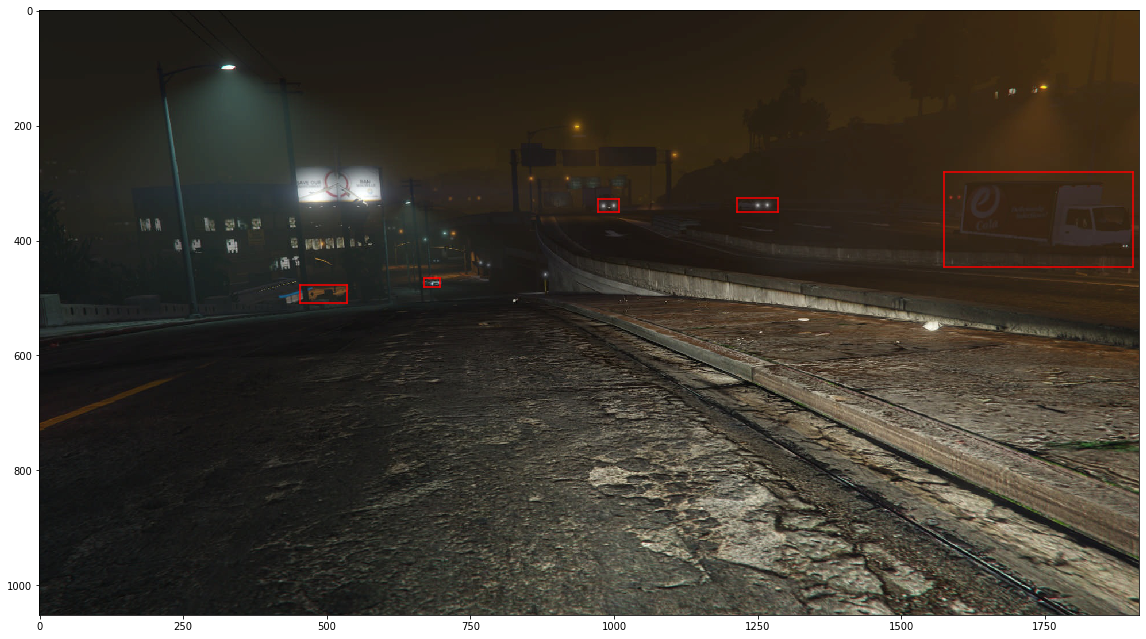

In [23]:
#Visualize bboxes on random image 

#%cd "/content/drive/My Drive/rob535/stage1"
os.chdir(STAGE_1)
%matplotlib inline
with open("calculated_bbox-test.pkl", 'rb') as handle:
    bbox_calc = pickle.load(handle)

#print(len(bbox_calc))
i = np.random.randint(0, len(bbox_calc))

# for j, bbox in enumerate(bbox_calc):
#   if bbox["path"] == 	"/content/drive/My Drive/rob535/test/eccfbc47-1e2f-4754-9fa7-4f56903cd13d/0020_image.jpg":
#     i = j
#     break

img = plt.imread(bbox_calc[i]["path"])

fig1 = plt.figure(1, figsize=(16, 9))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.imshow(img)
ax1.axis('scaled')
fig1.tight_layout()

print(bbox_calc[i]["path"])
print(bbox_calc[i]["label"])

for j in range(0, len(bbox_calc[i]["bbox"])):
  xmin = min(bbox_calc[i]["bbox"][j][1], bbox_calc[i]["bbox"][j][3])*1914
  xmax = max(bbox_calc[i]["bbox"][j][1], bbox_calc[i]["bbox"][j][3])*1914
  ymin = min(bbox_calc[i]["bbox"][j][0], bbox_calc[i]["bbox"][j][2])*1052
  ymax = max(bbox_calc[i]["bbox"][j][0], bbox_calc[i]["bbox"][j][2])*1052


  clr="red"
  ax1.plot([xmin, xmax], [ymin, ymin], color=clr)
  ax1.plot([xmin, xmin], [ymin, ymax], color=clr)
  ax1.plot([xmin, xmax], [ymax, ymax], color=clr)
  ax1.plot([xmax, xmax], [ymin, ymax], color=clr)
